In [1]:
!pip install --upgrade pip
!pip install tensorflow

     |████████████████████████████████| 1.5 MB 5.4 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
     |██████████████████▉             | 304.4 MB 133.8 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 516.2 MB 11 kB/s /s eta 0:00:01
     |████████████████████████████████| 104 kB 102.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 62.0 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 4.2 MB/s  eta 0:00:01
     |████████████████████████████████| 3.0 MB 49.8 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.4 MB/s  eta 0:00:01
     |████████████████████████████████| 454 kB 101.7 MB/s eta 0:00:01
     |████████████████████████████████| 777 kB 56.3 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 94.4 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 97.6 MB/s eta 0:00:01
  Created wheel for absl-py: filename=absl_py-0.9.0-py3-none-any.whl size=121931 sha256=a6ee290418f9b3e

In [11]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib import dates

from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.tsa.vector_ar.var_model import VAR

# import pyflux as pf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

import tensorflow as tf
keras = tf.keras
# from tensorflow import keras
# from tf.keras.models import Sequential
# from tf.keras.layers import Dense, Dropout, LSTM
# from tf.keras.prepocessing.sequence import TimeseriesGenerator


import os
from datetime import datetime


---
# User-defined Functions

In [12]:
def calc_rmse(actual, pred):
    """
    Calculates the root mean squared error.
    
    Parameters
    ----------
    actual : arr
       Actural prices from a valid dataset.
    
    pred : arr
        Forecasted prices derived from one of the time series models.
    
    Returns
    -------
    
    rmse : float
        RMSE for the two provided price curves.
    """
    return np.sqrt(mean_squared_error(actual, pred))



---
# Data Import and Processing

In [13]:
def import_process_data():
    caiso = pd.read_csv('data/caiso_master.csv')
    caiso.drop('Unnamed: 0', axis=1, inplace=True)
    caiso['INTERVAL_START_PT'] = pd.to_datetime(caiso['INTERVAL_START_PT']).apply(lambda x: x.replace(tzinfo=None))
    caiso['INTERVAL_END_PT'] = pd.to_datetime(caiso['INTERVAL_END_PT']).apply(lambda x: x.replace(tzinfo=None))
    caiso['date_hour_start'] = pd.to_datetime(caiso['date_hour_start']).apply(lambda x: x.replace(tzinfo=None))
    caiso['OPR_DT_PT'] = pd.to_datetime(caiso['OPR_DT_PT']).apply(lambda x: x.replace(tzinfo=None))
    caiso.set_index('INTERVAL_START_PT', inplace=True)
    caiso.rename({'HH_$_million_BTU_not_seasonal_adj': 'HH_$_mill_BTU', 'total_mw':'total_gen'},axis=1, inplace=True)
    caiso['HH_$_mill_BTU'] = pd.to_numeric(caiso['HH_$_mill_BTU'])
    return caiso

In [14]:
caiso = import_process_data()

In [15]:
# caiso.reset_index(inplace=True)

In [16]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)

13574144/13568290 [==============================] - 0s 0us/step


In [17]:
len(df)

420551

---
## Plot 

In [18]:
def plot_actual_arima_baselie_lstm(date_rng, y_true, arima_pred, baseline_pred, lstm_pred,  plot_title):
    """
    Comparative plot of actual and predicted prices for each forecasting method.
    
    Parameters
    ----------
    date_rng : arr
       A range of the datetime objects for forecast period.
    
    y_true : arr
        Actual price prices for the forecast period.
    
    arima_pred: arr
        Forecasted prices derived from an ARIMA model.
    
    baseline_pred: arr
        Forecasted prices derived from baseline model.
    
    lstm_pred : arr
        Forecasted prices derived from LSTM.
    
    plot_title : str
        Title for the plot.
        
    Returns
    -------
    
    """
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,10), sharex=True)
    axs[0].plot(date_rng, y_true, 'r.', label='Actual', markersize=12, )
    axs[0].plot(date_rng, baseline_pred, 'lightgrey', label='Baseline', lw=3, alpha=0.7)
    axs[0].plot(date_rng, arima_pred, 'g-', label='ARIMA', lw=3, alpha=0.7)
    
#     axs[0].set_title(plot_title, fontsize=22, fontweight='bold')
    axs[0].set_ylabel('$ / MWh', fontsize=14)
    axs[0].set_ylim(0, 50)
    axs[0].set_xlim(date_rng.min(), date_rng.max())
    axs[0].legend()
          
    axs[1].plot(date_rng, y_true, 'r.', label='Actual', markersize=12)
    axs[1].plot(date_rng, baseline_pred, 'lightgrey', label='Baseline', lw=3, alpha=0.7)      
    axs[1].plot(date_rng, lstm_pred, 'b', label='LSTM', lw=3, alpha=0.7)
    
    axs[1].set_ylabel('$ / MWh', fontsize=14)
    axs[1].set_ylim(0, 50)
    axs[1].set_xlim(date_rng.min(), date_rng.max())    
    axs[1].legend()
    
    plt.tight_layout();
    
#     plt.savefig('preso/np15_10_day_fcst.png', bbox_inches='tight')

---
# ARIMA Univariate Functions

In [19]:
def arima_uni_var_train_valid_split(lmp_curve, date_rng, train_split_idx):
    """
    Splits the provided priced curve - i.e. lmp_curve - into train and validation for us in the ARIMA model.
    
    Parameters
    ----------
    lmp_curve : arr
       Historic hourly prices for either NP15, SP15 or ZP26
    
    date_rng : arr
        Values are hourly timestamps that correspond to hourly prices
    
    train_split_index : int
        The index that is used to split the univarite time series into train and validation datasets.
    
    Returns
    -------
    
    lmp_train_curve : arr
        Prices used to train ARIMA model.
    
    lmp_valid_curve : arr
        Prices used to validate ARIMA model's hourly price forecast.
    
    date_train_rng : arr
        Dates and times used to train ARIMA model.
    
    date_valid_rng : arr
        Dates used to validate ARIMA model's hourly price forecast.
    """
    
    lmp_train_curve = lmp_curve[:train_split_idx]
    lmp_valid_curve = lmp_curve[train_split_idx:]
    date_train_rng = date_rng[:train_split_idx]
    date_valid_rng = date_rng[train_split_idx:]
    return lmp_train_curve, lmp_valid_curve, date_train_rng, date_valid_rng

def arima_uni_var_fit(lmp_train, date_rng, p, d, q):
    """
    Fits a univariate ARIMA model
    
    Parameters
    ----------
    lmp_train : arr
       Prices used to train ARIMA model.
    
    date_rng : arr
        Dates and times used to train ARIMA model.
        
    p : int
        The number of lag observations included in the model, commonly referred to as the lag order.
    
    d : int
        The number of times that the raw observations are differenced, commonly referred to as the degree of differencing.
    
    q : int
        The size of the moving average window.
    
    Returns
    -------
    
    ARIMA : object
        A fitted model to be used for predicting hourly electricity prices.
    """
    
    return ARIMA(endog=lmp_train, dates=date_rng, order=(p, d, q), freq='H').fit()

def arima_uni_var_predict(model, n_period_fcst):
    """
    Fits a univariate ARIMA model
    
    Parameters
    ----------
    model : object
       A fitted ARIMA model used to forecast hourly prices.
    
    n_period_fcst : int
        Number of hours to forecast
    
    Returns
    --------
    
    Prediction: arr
        An array of forecasted electricity prices
    """
    
    return model.forecast(steps=n_period_fcst)[0]

def plot_lstm_v_arima_vs_actuals(y_true, y_lstm, y_arima, date_rng):
    fig, ax = plt.subplots(figsize=(20,6))
    ax.plot(date_rng, y_lstm, 'g.-', label='LSTM', lw=2)
    ax.plot(date_rng, y_arima, 'b.-', label='ARIMA', lw=2)
    ax.plot(date_rng, y_true, 'r.', label='Actual')
    ax.set_title('Prediction vs Actual', fontsize=18, fontweight='bold')
    ax.set_xlabel('$/MWh', fontsize=12)
    ax.legend();



# Baseline Model Function

In [20]:
def baseline_fcst(lmp_curve, n_periods_fcst):
    """
    Calculated a baseline forecast based on average historic price.
    
    Parameters
    ----------
    lmp_curve : arr
       Historic electricity price curves
    
    n_periods_fcst : int
        Number of periods to forecast.
        
    Returns
    -------
    
    ARIMA : object
        A fitted model to be used for predicting hourly electricity prices.
    """
    
    avg = lmp_curve.mean()
    return np.full(n_periods_fcst, avg)

# LSTM Univariate Functions

In [26]:
# Add description.

def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

def split_and_windowize(data, n_prev, fraction_test=0.3):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

def lstm_uni_train_test_split(lmp_curve, n_prev, date_delim_idx):
    lmp_train = lmp_curve[:date_delim_idx]
    lmp_test = lmp_curve[date_delim_idx:]
    X_train, y_train = windowize_data(lmp_train, n_prev)
    X_test, y_test = windowize_data(lmp_test, n_prev)
    return X_train, X_test, y_train, y_test

def windowized_univariate_data(dataset, start_index, end_index, history_size, target_size):
    """
    Source: tensorflow.org
    
    Parameters
    ----------
    
    history_size : int
        The number of data points to include in window.
    
    target_size: int
        The number of hours to predict into the future.
        
    """
    
    
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = list(range(i-history_size, i))
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.array(dataset[indices]).reshape(-1,1))
        labels.append(dataset.iloc[i+target_size])
    return np.array(data), np.array(labels)

def standardize_data(data, train_split):
    data_mean = data[:train_split].mean()
    data_std = data[:train_split].std()
    return (data - data_mean) / data_std

def compile_and_fit_lstm_uni_var(X_train, y_train, batch_size, n_nodes=32, n_epochs=20):
    """
    Compiles and fits a three-layered univariate LSTM model
    
    Parameters
    ----------
    X_train : arr
        Indepedent variable, i.e. historic price, that has been windowized.
    
    y_train : arr
        Depedent variable, i.e. historic price, that has been windowized.
    
    batch_size : int
        Number of train examples used in each iteration.
    
    n_nodes : nodes
        Number of notes at each layer.
    
    n_epocs : int
        Number times that the LSTM model will work through the entire training dataset. 
    
    Returns
    -------
    
    lstm_uni : object
        A compiled and trained LSTM model.
    """
    n_features = X_train.shape[2]

    lstm_uni = keras.Sequential()
    lstm_uni.add(keras.layers.LSTM(n_nodes, input_shape=(batch_size, n_features), return_sequences=True))
    lstm_uni.add(keras.layers.LSTM(n_nodes, return_sequences=True))
    lstm_uni.add(keras.layers.LSTM(n_nodes, return_sequences=False))
    lstm_uni.add(keras.layers.Dense(1, activation='linear'))
    lstm_uni.compile(optimizer='adam',loss='mse')
    
    lstm_uni.fit(X_train, y_train, batch_size, n_epochs)
    
    return lstm_uni

def lstm_uni_pred(model, x_valid):
    """
    Predicts future prices based on an univarite LSTM model.
    
    Parameters
    ----------
    model: object
        A LSTM model that has been fitted to the training data for a specific CAISO hub.
    
    x_valid : arr
        Indepedent data that is used to predict future electricity prices.
    
    Returns
    -------
    
    predicted values : arr
        An array comprised of predicted electricty prices derived from the provided LSTM model
    """
    return model.predict(x_valid)

### Updated LSTM Code

In [24]:
def create_windows(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


def scale_split_windowize(price_curve, scale_min, scale_max, look_back, n_hrs_fcst):
    price_curve_reshaped = np.asarray(price_curve).reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
    price_curve_scld = scaler.fit_transform(price_curve_reshaped)
    
    train_split = len(price_curve) - (look_back + n_hrs_fcst) -1
    train_curve = price_curve_scld[0: train_split, :]
    test_curve = price_curve_scld[train_split:, :]
    
    X_train, y_train = create_windows(train_curve, look_back)
    X_test, y_test = create_windows(test_curve, look_back)
    
    X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    return X_train_reshaped, X_test_reshaped, y_train, y_test, scaler

def inverse_scaler(y_train, y_train_pred, y_test, y_test_pred, scaler):   
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
    y_train_pred_inv = scaler.inverse_transform(y_train_pred.reshape(-1,1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    y_test_pred_inv = scaler.inverse_transform(y_test_pred.reshape(-1,1))
    return y_train_inv, y_train_pred_inv, y_test_inv, y_test_pred_inv

def build_lstm_model(n_nodes, n_epochs, batch_size, X_train, y_train, X_test, y_test):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(n_nodes, input_shape =(X_train.shape[1], X_train.shape[2]), return_sequences=True))
#   lstm_uni.add(keras.layers.LSTM(n_nodes, return_sequences=True))
#   model.add(keras.layers.Dropout(rate=drop_rate))
    model.add(keras.layers.LSTM(n_nodes, return_sequences=False))
    model.add(keras.layers.Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics='accuracy')
    
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test), shuffle=False)
    
    return model

---
# NP-15

#### ARIMA Univariate Forecast

In [104]:
# To work w/ ARIMA - caiso.index.to_period('H')
np15_lmp = caiso['$_MWH_np15']
datetime_arima = caiso.index.to_period('H')

In [106]:
arima_train_split = len(caiso) - 240
np15_arima_train, np15_arima_test, date_arima_train, data_arima_test = arima_uni_var_train_valid_split(np15_lmp, datetime_arima, arima_train_split)
np15_arima_train.shape, np15_arima_test.shape, date_arima_train.shape, data_arima_test.shape

((11279,), (240,), (11279,), (240,))

In [107]:
# np_uni_train, np_uni_valid, np_train_rng, np_valid_rng = arima_uni_var_train_valid_split(np_lmp_arr, datetime_arr, 11270)
np15_arima_model = arima_uni_var_fit(np15_arima_train, date_arima_train, 24, 1, 0)

np_uni_arima_pred = arima_uni_var_predict(np15_arima_model, 240)

rmse_np_uni_arima = round(calc_rmse(np15_arima_test, np_uni_arima_pred), 6)
print(f"RMSE: {rmse_np_uni_arima}")

RMSE: 3.7047


### Baseline - Historic Average

In [111]:
base_pred = baseline_fcst(np15_arima_train, len(np15_arima_test))
rmse_np_baseline = round(calc_rmse(base_pred, np15_arima_test), 6)
print(f"RMSE - Baseline: {rmse_np_baseline}")

RMSE - Baseline: 9.538407


---
## LSTM Univariate

Keras uses fast symbolic mathematical libraries as a backend, such as TensorFlow and Theano.

A downside of using these libraries is that the shape and size of your data must be defined once up front and held constant regardless of whether you are training your network or making predictions.

On sequence prediction problems, it may be desirable to use a large batch size when training the network and a batch size of 1 when making predictions in order to predict the next step in the sequence.

The batch size is used when fitting your model controls how many predictions you must make at a time.

## Scaled Features

In [172]:
X_train_np15, X_test_np15, y_train_np15, y_test_np15, scaler = scale_split_windowize(caiso['$_MWH_np15'], -1, 1, 24, 240)
X_train_np15.shape, X_test_np15.shape, y_train_np15.shape, y_test_np15.shape

((11229, 1, 24), (240, 1, 24), (11229,), (240,))

In [173]:
test_lstm = build_lstm_model(32, 20, 250, X_train_np15, y_train_np15, X_test_np15, y_test_np15)

Epoch 1/20
45/45 [==============================] - 1s 16ms/step - loss: 0.0131 - accuracy: 0.0000e+00 - val_loss: 7.0681e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0067 - accuracy: 0.0000e+00 - val_loss: 7.0686e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0048 - accuracy: 0.0000e+00 - val_loss: 4.2160e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0035 - accuracy: 0.0000e+00 - val_loss: 2.7908e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 1.6953e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0023 - accuracy: 8.9055e-05 - val_loss: 1.2275e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0021 - accura

In [174]:
test_lstm.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 1, 32)             7296      
_________________________________________________________________
lstm_57 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 15,649
Trainable params: 15,649
Non-trainable params: 0
_________________________________________________________________


In [175]:
y_pred_train_np15 = lstm_model_1.predict(X_train_np15)
y_pred_test_np15 = lstm_model_1.predict(X_test_np15)

y_train_np15_inv, y_pred_train_np15_inv, y_test_np15_inv, y_pred_test_np15_inv = inverse_scaler(y_train_np15, y_pred_train_np15, y_test_np15, y_pred_test_np15, scaler)

rmse_train_np15 = calc_rmse(y_train_np15_inv, y_pred_train_np15_inv)
rmse_test_np15 = calc_rmse(y_test_np15_inv, y_pred_test_np15_inv)

print("RMSE Train - NP15 - Univariate LSTM: ", rmse_train_np15)
print("RMSE Test - NP15 - Univariate LSTM: ", rmse_test_np15)

RMSE Train - NP15 - Univariate LSTM:  8.064150548256212
RMSE Test - NP15 - Univariate LSTM:  1.9012457754214158


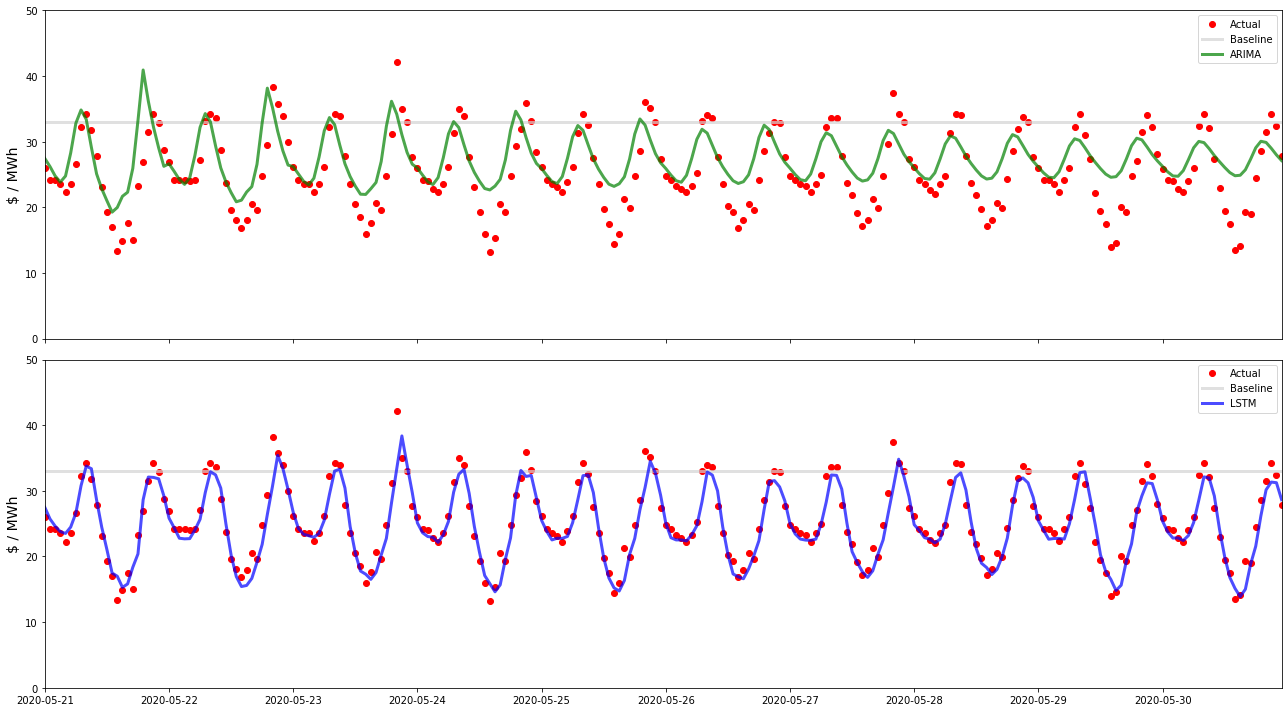

In [176]:
plot_actual_arima_baselie_lstm(caiso.index[arima_train_split:], y_test_np15_inv, np_uni_arima_pred, base_pred, y_pred_test_np15_inv, 'NP15 Ten-Day Forecast')

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5))

# epochs_rng = list(range(1, n_epochs+1))
# xticks_rng = np.arange(2, n_epochs+1, 2)
# ax.plot(epochs_rng, test_lstm.history['loss'], c='g', linewidth=2, label='Train')
# ax.plot(epochs_rng, test_lstm.history['val_loss'], c='b', linewidth=2, label='Test')
# ax.set_title('LSTM Model Loss', fontsize=20)
# ax.set_xlabel('Epoch')
# ax.set_xticks(xticks_rng)
# ax.legend()

# plt.tight_layout();

---
## Not Scaled

In [140]:
np15_lmp = np.asarray(caiso['$_MWH_np15'])
np15_lmp = np15_lmp.reshape(-1, 1)

look_back = 24
n_hrs_fcst = 240

train_split = len(np15_lmp) - look_back - n_hrs_fcst - 1 
# test_size = len(np15_lmp_scld) - train_size

np15_train, np15_test = np15_lmp[0:train_split, :], np15_lmp[train_split: , :]


def create_windows(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X_train_np15, y_train_np15 = create_windows(np15_train, look_back=24)
X_test_np15, y_test_np15 = create_windows(np15_test, look_back=24)

X_train_np15 = np.reshape(X_train_np15, (X_train_np15.shape[0], 1, X_train_np15.shape[1]))
X_test_np15 = np.reshape(X_test_np15, (X_test_np15.shape[0], 1, X_test_np15.shape[1]))

In [ ]:
# n_nodes = 32
# n_epochs = 20
# batch_size = 250
# drop_rate=0.2


# lstm_model_2 = keras.Sequential()
# lstm_model_2.add(keras.layers.LSTM(n_nodes, input_shape =(X_train_np15.shape[1], X_train_np15.shape[2]), return_sequences=True))
# #lstm_model_1.add(keras.layers.LSTM(n_nodes, return_sequences=True))
# #lstm_model_1.add(keras.layers.Dropout(rate=drop_rate))
# lstm_model_2.add(keras.layers.LSTM(n_nodes,return_sequences=False))
# lstm_model_2.add(keras.layers.Dense(1, activation='linear'))
# lstm_model_2.compile(optimizer='adam', loss='mse')

# history_2 = lstm_model_2.fit(X_train_np15, y_train_np15, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test_np15, y_test_np15), verbose=1, shuffle=False)

In [144]:
y_pred_train_np15_2 = lstm_model_2.predict(X_train_np15)
y_pred_test_np15_2 = lstm_model_2.predict(X_test_np15)

rmse_train_np15 = calc_rmse(y_train_np15, y_pred_train_np15_2)
rmse_test_np15 = calc_rmse(y_test_np15, y_pred_test_np15_2)

print("RMSE Train - NP15 - Univariate LSTM: ", rmse_train_np15)
print("RMSE Test - NP15 - Univariate LSTM: ", rmse_test_np15)

RMSE Train - NP15 - Univariate LSTM:  23.173325711565127
RMSE Test - NP15 - Univariate LSTM:  5.802447204541704


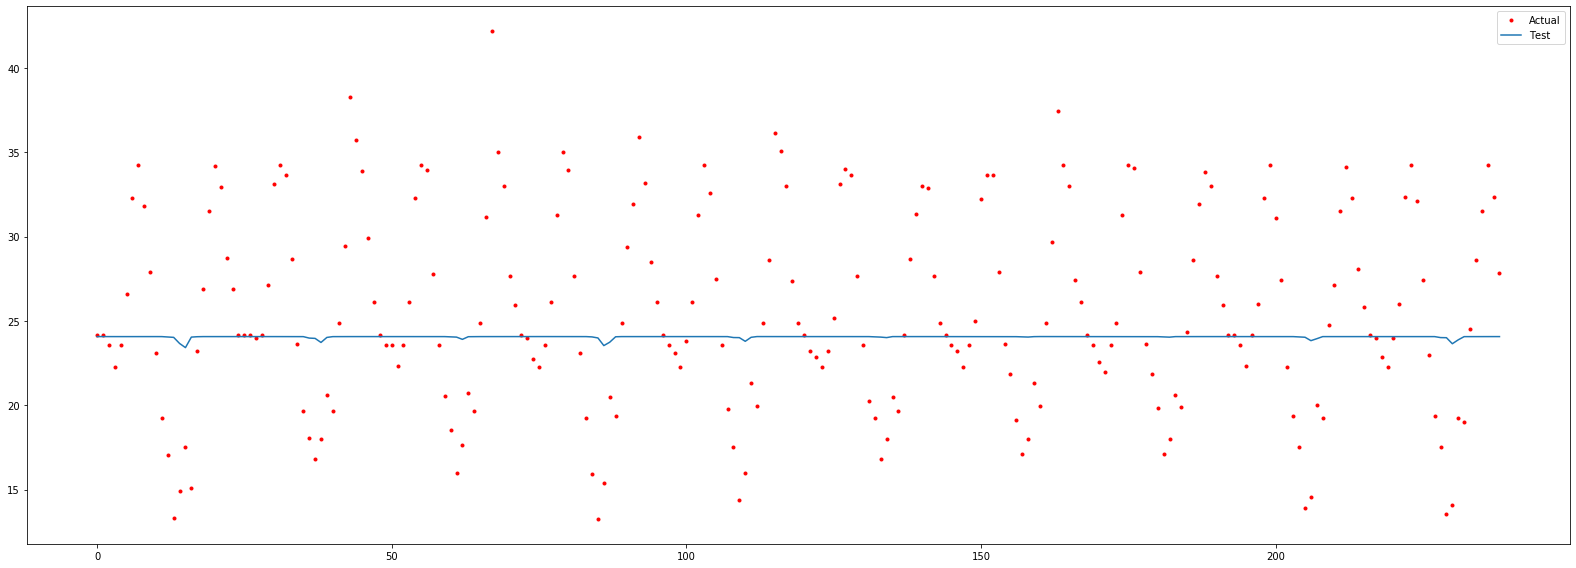

In [282]:
fig, ax = plt.subplots(figsize=(22,8))

date_rng = list(range(len(y_test_np15)))
ax.plot(date_rng, y_test_np15, 'r.', label="Actual")
ax.plot(date_rng, y_pred_test_np15, label='Test')
# ax.plot(date_rng,  np_uni_arima_pred, 'g--', label='baseline')
ax.legend()
plt.tight_layout(); 

---
### Multivariate LSTM 

LSTMs offer a number of benefits when it comes to multi-step time series forecasting; they are:

**Native Support for Sequences.** LSTMs are a type of recurrent network, and as such are designed to take sequence data as input, unlike other models where lag observations must be presented as input features.

**Multivariate Inputs.** LSTMs directly support multiple parallel input sequences for multivariate inputs, unlike other models where multivariate inputs are presented in a flat structure.

**Vector Output.** Like other neural networks, LSTMs are able to map input data directly to an output vector that may represent multiple output time steps.

In [27]:
caiso.head()

,INTERVAL_END_PT,date_hour_start,OPR_DT_PT,OPR_HR_PT,day_week,OPR_INTERVAL,$_MWH_np15,$_MWH_sp15,$_MWH_zp26,other,solar,wind,total_gen,net_exp_MW,load_MW,HH_$_mill_BTU
INTERVAL_START_PT,,,,,,,,,,,,,,,,
2019-02-01 01:00:00,2019-02-01 02:00:00,2019-02-01 01:00:00,2019-02-01,1,4,0,36.62123,36.04269,36.05743,19179.16,71.63,531.70,19782.49,-113560.63,318054.0,2.7
2019-02-01 02:00:00,2019-02-01 03:00:00,2019-02-01 02:00:00,2019-02-01,2,4,0,35.84812,35.15389,35.19706,19252.28,0.27,513.50,19766.05,-111822.96,328601.0,2.7
2019-02-01 03:00:00,2019-02-01 04:00:00,2019-02-01 03:00:00,2019-02-01,3,4,0,35.60431,34.87623,34.92977,18500.98,0.00,456.11,18957.09,-111927.13,322692.0,2.7
2019-02-01 04:00:00,2019-02-01 05:00:00,2019-02-01 04:00:00,2019-02-01,4,4,0,35.40240,34.69286,34.73189,17693.16,0.00,379.62,18072.78,-112259.17,313214.0,2.7
2019-02-01 05:00:00,2019-02-01 06:00:00,2019-02-01 05:00:00,2019-02-01,5,4,0,36.62816,36.03518,36.04623,16903.02,0.00,365.96,17268.98,-105529.79,297274.0,2.7


In [30]:
exo_vars = caiso[['other', 'solar', 'wind', 'load_MW']].copy()
exo_vars.index = caiso.index
exo_vars.head()

,other,solar,wind,load_MW
INTERVAL_START_PT,,,,
2019-02-01 01:00:00,19179.16,71.63,531.70,318054.0
2019-02-01 02:00:00,19252.28,0.27,513.50,328601.0
2019-02-01 03:00:00,18500.98,0.00,456.11,322692.0
2019-02-01 04:00:00,17693.16,0.00,379.62,313214.0
2019-02-01 05:00:00,16903.02,0.00,365.96,297274.0


<Figure size 1080x576 with 0 Axes>

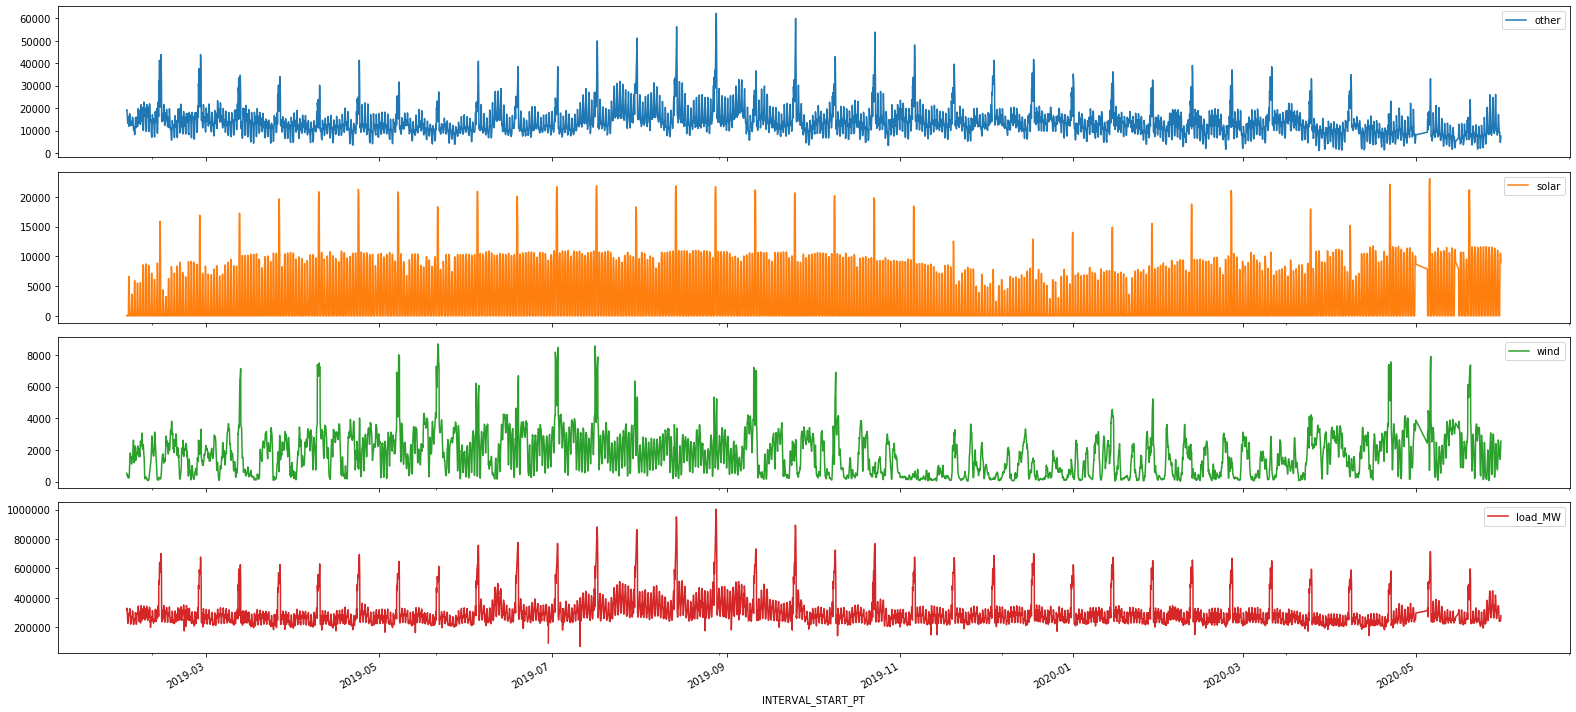

In [35]:
plt.figure(figsize=(15,8))
exo_vars.plot(subplots=True, figsize=(22,10))
plt.tight_layout();

In [ ]:
price_curve = 
exo_vars = 
scale_min =
scale_max = 
look_back = 
n_hrs_fcst = 

price_curve_reshaped = np.asarray(price_curve).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(scale_min, scale_max))

price_curve_scld = scaler.fit_transform(price_curve_reshaped)
exo_vars_scld = scaler.fit_transform(exo_vars.values)

train_split = len(price_curve) - (look_back + n_hrs_fcst) -1
train_curve = price_curve_scld[0: train_split, :]
test_curve = price_curve_scld[train_split:, :]

train_exo_vars = exo_vars_scld[ : , 0:train_split]
test_exo_vars = exo_vars_scld[ : , train_split: ]

X_train, y_train = create_windows(train_curve, look_back)
X_test, y_test = create_windows(test_curve, look_back)

X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [69]:
multi_trial_data = caiso[['other', 'solar', 'wind', 'load_MW', '$_MWH_np15']].copy()

def series_to_supervised(dataset, n_inputs, n_outputs, dropnan=True):
    n_vars = dataset.shape[1]
    df = pd.DataFrame(dataset)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_inputs, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence(t + n, )
    for i in range(0, n_outputs):
        cols.append(df.shift(i))
        
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    final_data = pd.concat(cols, axis=1)
    final_data.columns = names
    
    if dropnan:
        final_data.dropna(inplace=True)
    
    return final_data
                       
    

In [67]:
series_to_supervised(multi_trial_data.values, 24, 240)

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),var5(t-23),...,var1(t+238),var2(t+238),var3(t+238),var4(t+238),var5(t+238),var1(t+239),var2(t+239),var3(t+239),var4(t+239),var5(t+239)
239,126.38923,12461.59,2298.84,2599.76,264700.00,152.51065,15716.33,225.63,2342.03,292566.00,...,35.84812,19252.28,0.27,513.50,328601.00,36.62123,19179.16,71.63,531.70,318054.00
240,152.51065,15716.33,225.63,2342.03,292566.00,138.05544,17029.66,0.31,2155.53,312557.00,...,35.60431,18500.98,0.00,456.11,322692.00,35.84812,19252.28,0.27,513.50,328601.00
241,138.05544,17029.66,0.31,2155.53,312557.00,127.09774,16481.62,0.00,1996.82,306289.00,...,35.40240,17693.16,0.00,379.62,313214.00,35.60431,18500.98,0.00,456.11,322692.00
242,127.09774,16481.62,0.00,1996.82,306289.00,118.32897,16113.97,0.00,1897.51,299331.00,...,36.62816,16903.02,0.00,365.96,297274.00,35.40240,17693.16,0.00,379.62,313214.00
243,118.32897,16113.97,0.00,1897.51,299331.00,119.31168,15538.39,0.00,1867.89,290541.00,...,42.66307,16003.96,0.01,386.10,274602.00,36.62816,16903.02,0.00,365.96,297274.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11514,31.52044,8835.00,11006.09,852.04,308791.87,34.11367,9311.35,10934.17,1045.18,314716.11,...,33.05000,4275.65,11391.67,1068.27,231859.04,37.06486,4094.19,11564.22,803.22,228817.93
11515,34.11367,9311.35,10934.17,1045.18,314716.11,32.27282,9257.59,10746.76,1389.55,322742.08,...,29.92643,5389.38,10922.21,1450.25,239081.30,33.05000,4275.65,11391.67,1068.27,231859.04
11516,32.27282,9257.59,10746.76,1389.55,322742.08,28.05452,10789.25,10236.02,1855.70,332976.47,...,25.95798,6157.79,10140.58,1885.15,252875.89,29.92643,5389.38,10922.21,1450.25,239081.30
11517,28.05452,10789.25,10236.02,1855.70,332976.47,25.83565,11876.48,9310.65,2302.93,339926.44,...,24.15000,7460.16,8328.71,2291.56,272123.27,25.95798,6157.79,10140.58,1885.15,252875.89


In [72]:
scaler = MinMaxScaler(feature_range=(-1,1))
multi_trial_scaled = scaler.fit_transform(multi_trial_data)
multi_reframed_super = series_to_supervised(multi_trial_scaled, 24, 241)
multi_reframed_super.head()

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),var5(t-23),...,var1(t+239),var2(t+239),var3(t+239),var4(t+239),var5(t+239),var1(t+240),var2(t+240),var3(t+240),var4(t+240),var5(t+240)
240,-0.521792,-0.980421,-0.466346,-0.518998,0.492273,-0.478884,-0.999973,-0.509341,-0.476258,0.421111,...,-0.406270,-0.999977,-0.887890,-0.441956,-0.082049,-0.408659,-0.993784,-0.883694,-0.464505,-0.078243
241,-0.478884,-0.999973,-0.509341,-0.476258,0.421111,-0.496789,-1.000000,-0.545930,-0.489659,0.367167,...,-0.430816,-1.000000,-0.901120,-0.454589,-0.083250,-0.406270,-0.999977,-0.887890,-0.441956,-0.082049
242,-0.496789,-1.000000,-0.545930,-0.489659,0.367167,-0.508800,-1.000000,-0.568824,-0.504535,0.323999,...,-0.457208,-1.000000,-0.918754,-0.474853,-0.084244,-0.430816,-1.000000,-0.901120,-0.454589,-0.083250
243,-0.508800,-1.000000,-0.568824,-0.504535,0.323999,-0.527605,-1.000000,-0.575653,-0.523328,0.328837,...,-0.483022,-1.000000,-0.921903,-0.508933,-0.078209,-0.457208,-1.000000,-0.918754,-0.474853,-0.084244
244,-0.527605,-1.000000,-0.575653,-0.523328,0.328837,-0.561897,-1.000000,-0.580995,-0.556127,0.348485,...,-0.512395,-0.999999,-0.917260,-0.557405,-0.048500,-0.483022,-1.000000,-0.921903,-0.508933,-0.078209


---
# SP-15

### Data Preparation

In [ ]:
# SP15 Data Preparation
sp15_lmp = caiso['$_MWH_sp15']
sp15_lmp.index = caiso.index
sp15_lmp_std = standardize_data(sp15_lmp, train_split)

### Univariate ARIMA Model

In [178]:
sp15_lmp = caiso['$_MWH_sp15']
arima_train_split = len(caiso) - 240
sp15_arima_train, sp15_arima_test, date_arima_train, data_arima_test = arima_uni_var_train_valid_split(sp15_lmp, datetime_arima, arima_train_split)
sp15_arima_train.shape, sp15_arima_test.shape, date_arima_train.shape, data_arima_test.shape

((11279,), (240,), (11279,), (240,))

In [181]:
sp15_arima_model = arima_uni_var_fit(sp15_arima_train, date_arima_train, 24, 1, 0)

sp_uni_arima_pred = arima_uni_var_predict(sp15_arima_model, 240)

rmse_sp_arima = round(calc_rmse(sp15_arima_test, sp_uni_arima_pred), 6)
print(f"RMSE: {rmse_sp_arima}")

RMSE: 4.186597


### Baseline Model

In [182]:
base_pred_sp = baseline_fcst(sp15_arima_train, len(sp15_arima_test))
rmse_sp_baseline = round(calc_rmse(base_pred_sp, sp15_arima_test), 6)
print(f"RMSE - Baseline: {rmse_sp_baseline}")

RMSE - Baseline: 9.295039


### Univariate LSTM Model

In [183]:
X_train_sp15, X_test_sp15, y_train_sp15, y_test_sp15, scaler = scale_split_windowize(caiso['$_MWH_sp15'], -1, 1, 24, 240)
X_train_sp15.shape, X_test_sp15.shape, y_train_sp15.shape, y_test_sp15.shape

((11229, 1, 24), (240, 1, 24), (11229,), (240,))

In [184]:
lstm_model_sp = build_lstm_model(32, 20, 250, X_train_sp15, y_train_sp15, X_test_sp15, y_test_sp15)

Epoch 1/20
45/45 [==============================] - 1s 16ms/step - loss: 0.0136 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 2/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 3/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0060 - accuracy: 0.0000e+00 - val_loss: 7.2837e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0044 - accuracy: 0.0000e+00 - val_loss: 4.7694e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 2.9564e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 8.9055e-05 - val_loss: 2.3613e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0024 - accuracy: 8.90

In [185]:
y_pred_train_sp15 = lstm_model_sp.predict(X_train_sp15)
y_pred_test_sp15 = lstm_model_sp.predict(X_test_sp15)

y_train_sp15_inv, y_pred_train_sp15_inv, y_test_sp15_inv, y_pred_test_sp15_inv = inverse_scaler(y_train_sp15, y_pred_train_sp15, y_test_sp15, y_pred_test_sp15, scaler)

rmse_train_sp15 = calc_rmse(y_train_sp15_inv, y_pred_train_sp15_inv)
rmse_test_sp15 = calc_rmse(y_test_sp15_inv, y_pred_test_sp15_inv)

print("RMSE Train - NP15 - Univariate LSTM: ", rmse_train_sp15)
print("RMSE Test - NP15 - Univariate LSTM: ", rmse_test_sp15)

RMSE Train - NP15 - Univariate LSTM:  7.1766561877858805
RMSE Test - NP15 - Univariate LSTM:  2.6315642954999428


### Comparative Plot

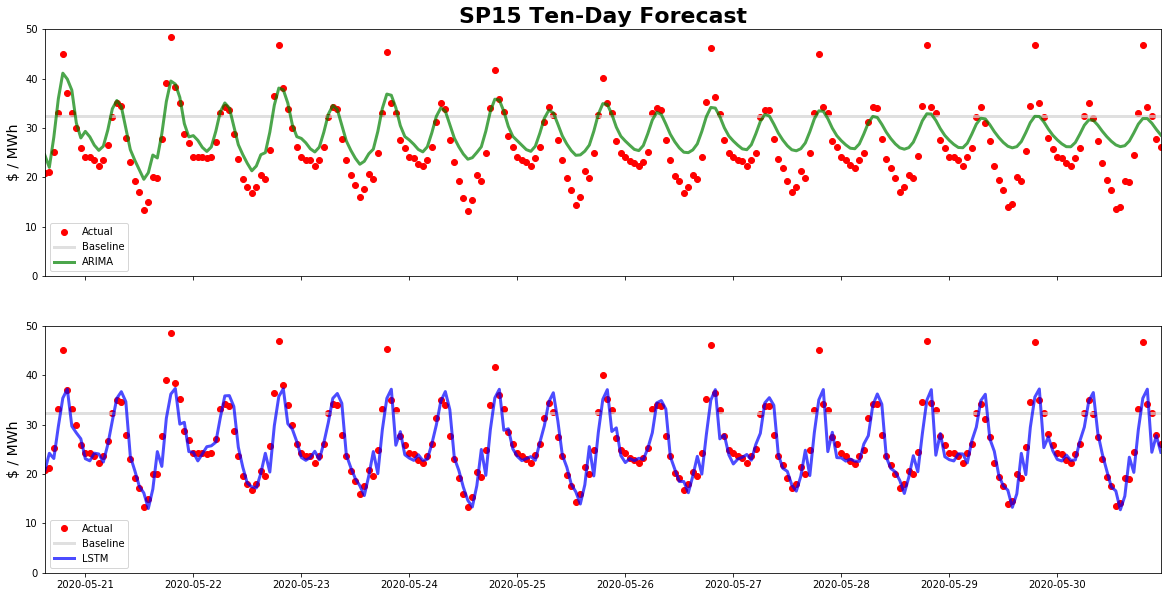

In [113]:
plot_actual_arima_baselie_lstm(caiso.index[arima_train_split:], y_test_sp15_inv, sp_uni_arima_pred, base_pred_sp, y_pred_test_sp15_inv, 'SP15 Ten-Day Forecast')

---
# ZP26

### Data Preparation

In [56]:

# ZP26 Data Preparation
zp26_lmp = caiso['$_MWH_zp26']
zp26_lmp.index = caiso.index
zp26_lmp_std = standardize_data(zp26_lmp, train_split)

### Univariable ARIMA Model

In [187]:
zp26_lmp = caiso['$_MWH_zp26']
arima_train_split = len(caiso) - 240
zp26_arima_train, zp26_arima_test, date_arima_train, data_arima_test = arima_uni_var_train_valid_split(zp26_lmp, datetime_arima, arima_train_split)
zp26_arima_train.shape, zp26_arima_test.shape, date_arima_train.shape, data_arima_test.shape

((11279,), (240,), (11279,), (240,))

In [188]:
zp26_arima_model = arima_uni_var_fit(zp26_arima_train, date_arima_train, 24, 1, 0)

zp26_uni_arima_pred = arima_uni_var_predict(zp26_arima_model, 240)



NameError: name 'rmse_zp26_arima' is not defined

In [189]:
rmse_zp26_arima = round(calc_rmse(zp26_arima_test, zp26_uni_arima_pred), 6)
print(f"RMSE: {rmse_zp26_arima}")

RMSE: 3.644963


### Basline Model

In [190]:
base_pred_zp26 = baseline_fcst(zp26_arima_train, len(zp26_arima_test))
rmse_zp26_baseline = round(calc_rmse(base_pred_zp26, zp26_arima_test), 6)
print(f"RMSE - Baseline: {rmse_zp26_baseline}")

RMSE - Baseline: 8.751937


### Univariate LSTM

In [191]:
X_train_zp26, X_test_zp26, y_train_zp26, y_test_zp26, scaler = scale_split_windowize(caiso['$_MWH_zp26'], -1, 1, 24, 240)
X_train_zp26.shape, X_test_zp26.shape, y_train_zp26.shape, y_test_zp26.shape

((11229, 1, 24), (240, 1, 24), (11229,), (240,))

In [192]:
lstm_model_zp26 = build_lstm_model(32, 20, 250, X_train_zp26, y_train_zp26, X_test_zp26, y_test_zp26)

Epoch 1/20
45/45 [==============================] - 1s 16ms/step - loss: 0.0130 - accuracy: 0.0000e+00 - val_loss: 8.0550e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0073 - accuracy: 0.0000e+00 - val_loss: 7.6176e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0055 - accuracy: 0.0000e+00 - val_loss: 5.2280e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0040 - accuracy: 0.0000e+00 - val_loss: 3.3435e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 1.7915e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - val_loss: 1.2148e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
45/45 [==============================] - 0s 4ms/step - loss: 0.0021 - accura

In [193]:
y_pred_train_zp26 = lstm_model_zp26.predict(X_train_zp26)
y_pred_test_zp26 = lstm_model_zp26.predict(X_test_zp26)

y_train_zp26_inv, y_pred_train_zp26_inv, y_test_zp26_inv, y_pred_test_zp26_inv = inverse_scaler(y_train_zp26, y_pred_train_zp26, y_test_zp26, y_pred_test_zp26, scaler)

rmse_train_zp26 = calc_rmse(y_train_zp26_inv, y_pred_train_zp26_inv)
rmse_test_zp26 = calc_rmse(y_test_zp26_inv, y_pred_test_zp26_inv)

print("RMSE Train - NP15 - Univariate LSTM: ", rmse_train_zp26)
print("RMSE Test - NP15 - Univariate LSTM: ", rmse_test_zp26)

RMSE Train - NP15 - Univariate LSTM:  7.2392900406667025
RMSE Test - NP15 - Univariate LSTM:  1.8742707996037928


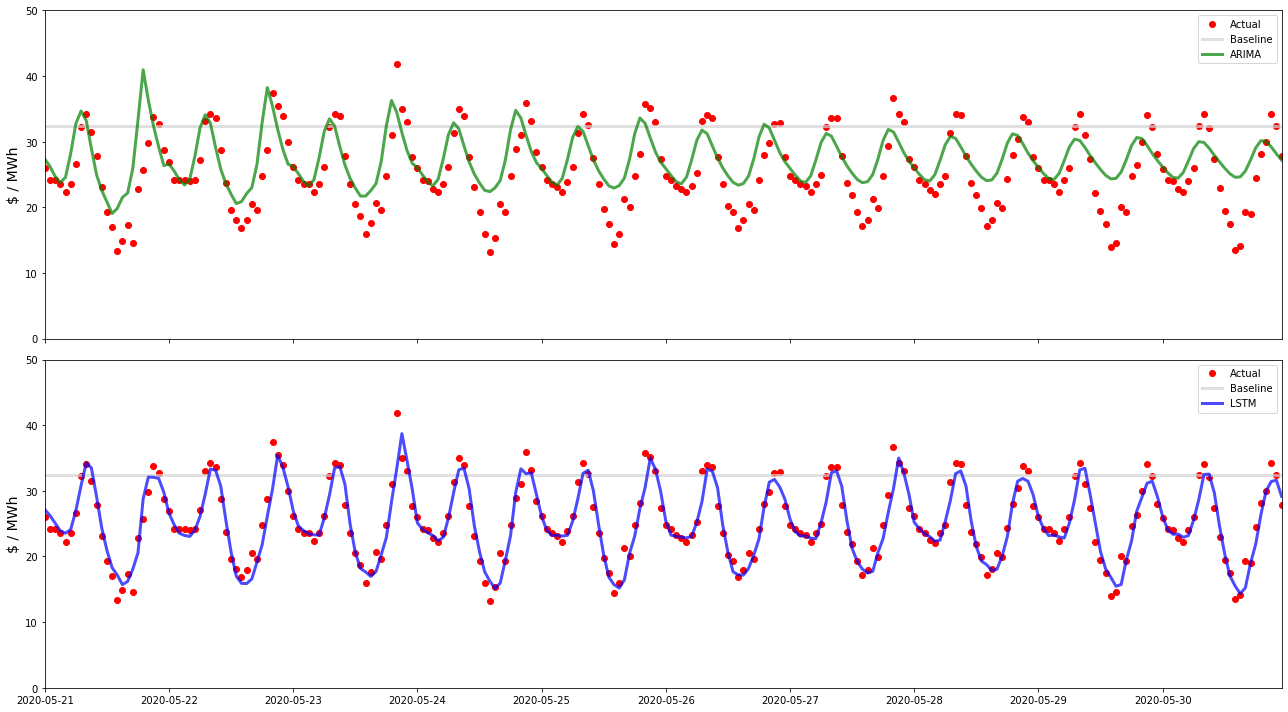

In [194]:
plot_actual_arima_baselie_lstm(caiso.index[arima_train_split:], y_test_zp26_inv, zp26_uni_arima_pred, base_pred_sp, y_pred_test_zp26_inv, 'ZP26 Ten-Day Forecast')


## Multivariate LSTM

### VAR - Multivariable

In [159]:
def multivariate_data_windowize_split(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    """"
    Source: https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series
    """
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset.iloc[indices, :])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [160]:
np_multi_lstm_features.index

RangeIndex(start=0, stop=11519, step=1)

In [161]:
np_multi_lstm_features = caiso[['load_MW', '$_MWH_np15', 'HH_$_mill_BTU', 'other', 'solar', 'wind']].copy().reset_index()
np_multi_lstm_features.drop('INTERVAL_START_PT', axis=1, inplace=True)
start_idx = np_multi_lstm_features.index[0]
end_idx = np_multi_lstm_features.index[train_test_date_delim_idx]
# Standardize dataset
np_multi_lstm_mean = np_multi_lstm_features[:train_test_date_delim_idx].mean(axis=0)
np_multi_lstm_std = np_multi_lstm_features[:train_test_date_delim_idx].std(axis=0)
np_multi_lstm_features = (np_multi_lstm_features - np_multi_lstm_mean) / np_multi_lstm_std

X2_train, y2_train = multivariate_data_windowize_split(np_multi_lstm_features, np_multi_lstm_features.iloc[:, 1], 0, train_test_date_delim_idx, 24*7, 
                                                       249, 1, single_step=True)

X2_test, y2_test = multivariate_data_windowize_split(np_multi_lstm_features, np_multi_lstm_features.iloc[:, 1], train_test_date_delim_idx, None, 24*7, 
                                                     249, 1, single_step=True)

ValueError: cannot copy sequence with size 168 to array axis with dimension 6

In [155]:
print ('Single window of past history : {}'.format(X2_train.shape))

Single window of past history : (11102, 168)


In [154]:
n_features = X2_train.shape[2]

IndexError: tuple index out of range

In [156]:


np_lstm_multi = keras.Sequential()
np_lstm_multi.add(keras.layers.LSTM(32, input_shape=X2_train.shape[-2:], return_sequences=True))
np_lstm_multi.add(keras.layers.LSTM(32, return_sequences=True))
np_lstm_multi.add(keras.layers.LSTM(32, return_sequences=False))
# The Dense value is the output sequence.
np_lstm_multi.add(keras.layers.Dense(1, activation='linear'))
np_lstm_multi.compile(optimizer='adam',loss='mse')

In [158]:
X2_train.shape[-2:]

(11102, 168)

In [157]:
np_lstm_multi.fit(X2_train, y2_train, batch_size, epochs=20)

Epoch 1/20


ValueError: in user code:

    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 168]
